# Shiftr: Simple, Clean Image Shifting Fun

First, run the cell below. You can do that using shift+Enter, or Cell>Run

In [20]:
%matplotlib inline
import os
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
from scipy.ndimage.interpolation import shift
from ipywidgets import interact, interactive, fixed
import ipywidgets as widgets
from IPython.display import display
import csv
import png


def plot_shift(im0, im, shift_y,shift_x):
    s=shift(im, [shift_y,shift_x])
    diff=s-im0
    fig, ax=plt.subplots(figsize=(12,8))
    ax.imshow(diff, cmap=plt.cm.bwr, clim=[-40,40])

Then run this cell to navigate to the correct directory on LINNA, or change it to point to a local directory on your computer. You should use the folder which contains two folders, Background and Shot. I do this by navigating to the folder using Explorer, then clicking the folder icon to the left of the path, which converts the path to text that you can copy and paste.

In [21]:
cd "\\linna\Users\Magpie\Documents\MAGPIE data\2015\August_2015\s0812_15 Bow shocks Al para 2\s0812_15"

\\linna\Users\Magpie\Documents\MAGPIE data\2015\August_2015\s0812_15 Bow shocks Al para 2\s0812_15


## Loading the data
Run the cell below to load the data. Backgrounds should be .jpg. Shots should be .tif. Both must be in separate folders called eg. "s0821_15 Background" and "s0821_15 Shot" and the files should be labeled eg "s0821_15 Shot_001"

In [23]:
shot=os.path.split(os.getcwd())[-1][0:8] #automatically grab the shot number
b=[]
s=[]
for i in range(1,13):
    if i<10:
        st="0"+str(i)
    else:
        st=str(i)
    bk_fn=shot+" Background/"+shot+" Background_0"+st+".jpg"
    bk_im=plt.imread(bk_fn) #read background image
    try:
        bk_im=np.asarray(np.sum(bk_im,2), dtype=float)
    except:
        bk_im=bk_im
    b.append(bk_im)#np.asarray(np.sum(bk_im,2), dtype=float)) #convert to grrayscale
    sh_fn=shot+" Shot/"+shot+" Shot_0"+st+".tif" 
    sh_im=plt.imread(sh_fn)
    s.append(sh_im)

bb=np.zeros((13, b[0].shape[0], b[0].shape[1])) #create an empty array to store the results
ss=np.zeros((13, s[0].shape[0], s[0].shape[1]))
bb[0]=b[0]
ss[0]=s[0]
shifts=np.zeros((13,2))

## Shifting the images
Change 'image' to be the desired image. Images are labelled from 1. You don't need to adjust image 1! 
Then run this cell. Use the sliders to achieve the best overlap. If you already have a list of shifts from a previous attempt, you can skip the next two steps and load it below.

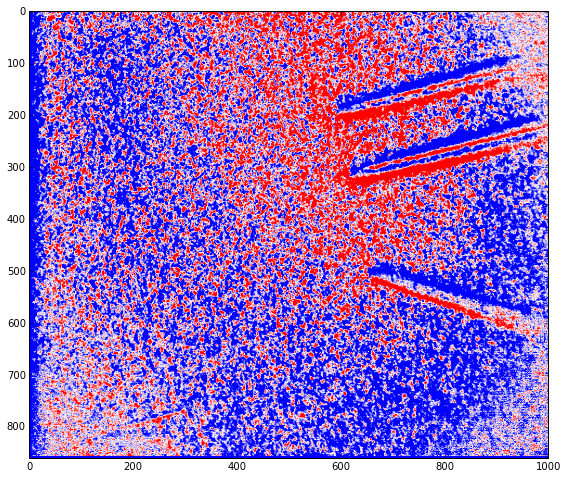

In [74]:
image=2
sy=widgets.FloatSlider(min=-20,max=20,step=0.5,value=0)
sx=widgets.FloatSlider(min=-20,max=20,step=0.5,value=0)
w=interactive(plot_shift, im0=fixed(b[0]), im=fixed(b[image-1]), shift_y=sy, shift_x=sx)
display(w)

Once you are happy with the overlap, run the cell below to shift the shot image. Then change 'image' in the cell above, run it, and repeat this step until all images have been shifted.

In [75]:
tx, ty=w.kwargs['shift_x'], w.kwargs['shift_y']
shifts[image-1]=(ty,tx)
bb[image-1]=sp.ndimage.shift(b[image-1], [ty,tx])
ss[image-1]=sp.ndimage.shift(s[image-1], [ty,tx])

## Loading Previous data
If you want to load previous data, first use the cell below to navigate to the correct directory, and then enter the file name at the top of the next cell.

In [77]:
cd "C:\Users\jdavies\Google Drive\MAGPIE\data\2015"

C:\Users\jdavies\Google Drive\MAGPIE\data\2015


In [78]:
filename='s0812_15 shifts'
with open(filename+'.txt', 'r') as f:
    reader = csv.reader(f, delimiter=',')
    next(reader)
    for row in reader:
        image=int(row[0])
        ty=float(row[1])
        tx=float(row[2])
        shifts[image-1]=(ty,tx)
        bb[image-1]=sp.ndimage.shift(b[image-1], [ty,tx])
        ss[image-1]=sp.ndimage.shift(s[image-1], [ty,tx])

## Saving the results
Change to the directory you want to put the files to.

In [26]:
cd "C:\Users\jdavies\Google Drive\MAGPIE\data\2015"

C:\Users\jdavies\Google Drive\MAGPIE\data\2015


Finally, run this cell below to save out all of the shifted background and shot images.

In [81]:
ss_n=[]
for i in range(0,12):
    cum_px=np.sort(ss[i].flatten())
    p99=x[int(-cum_px.size/100)]
    sn=ss[i]*2**16/p99
    sn=np.clip(sn, a_min=0, a_max=2**16-1)
    ss_n.append(sn)

for i in range(0,12):
    if i<9:
        st="0"+str(i+1)
    else:
        st=str(i+1)
    bkfn=shot+" Background_0"+st+".png"
    f = open(bkfn, 'wb')
    b_im=bb[i]
    pwriter = png.Writer(len(b_im[0]), len(b_im), greyscale=True, bitdepth=16)
    pwriter.write(f,b_im)
    f.close()
    shfn=shot+" Shot_0"+st+".png"
    f = open(shfn, 'wb')
    s_im=ss_n[i]
    pwriter = png.Writer(len(s_im[0]), len(s_im), greyscale=True, bitdepth=16)
    pwriter.write(f,s_im)
    f.close()
    
filename=shot+" shifts"
data=zip(range(1,13), shifts[:,0], shifts[:,1])
with open(filename+'.txt', 'w', newline='') as file:
    cwriter = csv.writer(file, delimiter=',')
    cwriter.writerow(['Image', 'Y Shift', 'X Shift'])
    for f in data:
        cwriter.writerow(f)